In [45]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import re
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mlines
from matplotlib import colors as mcolors
import matplotlib.backends.backend_pdf
import matplotlib.font_manager as font_manager
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [88]:
# Set the font dictionaries (for plot title and axis titles)
font_root = "/System/Library/Fonts"
font_base_name = "SFNSDisplayCondensed"
title_font = {'fontname': font_base_name + "-Regular", 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname': font_base_name + '-Bold', 'size':'14'}
font_path = os.path.join(font_root, font_base_name + '-Thin.otf')
font_path_bf = os.path.join(font_root, font_base_name + '-Regular.otf')
font_prop_title = font_manager.FontProperties(fname=font_path, size=40)
font_prop_axis = font_manager.FontProperties(fname=font_path, size=30)
font_prop_axis_labels = font_manager.FontProperties(fname=font_path, size=40)
font_prop_legend = font_manager.FontProperties(fname=font_path, size=26)
font_prop_legend_small = font_manager.FontProperties(fname=font_path, size=24)

#markers
lw = 4
ms = 200
colorlist = ['crimson','dodgerblue','darkorchid','forestgreen','goldenrod','silver','darkorange','turquoise'] \
            +[str(name) for name,hex in mcolors.cnames.items()]
markerlist = ['v','s','o','*','^','x','p','8','+','>','<']
xoff = 0.
xwidth = 0.4
xshift = 0.1

## General Functions

In [89]:
#old format
def parse_file(filename):
    token = re.findall(R"(.*?)_ngpu(.*?).out", os.path.basename(filename))[0]
    
    record = {"num_gpus": int(token[1]),
              "features": token[0]
             }
    
    with open(filename, "r") as f:
        lines = f.readlines()
    
    pattern_setup = re.compile(R"Setup: took (.*?)s")
    pattern = re.compile(R"Run (.*?): iterations took (.*?)s for (.*?) iterations")
    recordlist = []
    for line in lines:
        ps = pattern_setup.match(line)
        p = pattern.match(line)
        
        if ps is not None:
            psg = ps.groups()
            record = {"num_gpus": int(token[1]),
                      "feature": token[0],
                      "run": -1,
                      "total_time": float(psg[0]),
                      "num_iterations": 1
                     }
            recordlist.append(record)
        elif p is not None:
            pg = p.groups()
            record = {"num_gpus": int(token[1]),
                      "feature": token[0],
                      "run": int(pg[0]),
                      "total_time": float(pg[1]),
                      "num_iterations": int(pg[2])
                     }
            recordlist.append(record)
    
    return pd.DataFrame(recordlist)

#new format
def parse_file_new(filename):
    token = re.findall(R"timing_(.*?)_(.*?)_threads_nranks(.*?).out", os.path.basename(filename))[0]
    
    record = {"num_gpus": int(token[2]),
              "features": token[1],
              "loader": token[0]
             }
    
    with open(filename, "r") as f:
        lines = f.readlines()
    
    pattern = re.compile(R".*?root - INFO - total time / step = (.*?), fw time / step = (.*?), bw time / step = (.*?), exposed io time / step = (.*?), iters/s = (.*?), logging time = (.*?)")                        
    # first run is warmup
    counter = -1
    recordlist = []
    for line in lines:
        match = pattern.match(line)
        if match:
            psg = match.groups()
            rec = {"run": counter, 
                   "total_time": float(psg[0]),
                   "fw_time": float(psg[1]),
                   "bw_time": float(psg[2]),
                   "samples_per_second": float(psg[4]),
                   "num_gpus": record["num_gpus"],
                   "feature": record["features"],
                   "loader": record["loader"]
                    }
            recordlist.append(rec)
            counter += 1

    return pd.DataFrame(recordlist)

## Load Data

In [90]:
data_dir = "./results/dgx2"
files = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".out")]

dflist = []
for filename in files:
    dflist.append(parse_file_new(filename))

datadf = pd.concat(dflist).sort_values(by=["loader", "feature", "num_gpus"]).reset_index(drop=True)
#datadf["samples_per_second"] = datadf["num_iterations"] * datadf["num_gpus"] / datadf["total_time"]
datadf["samples_per_second"] *= datadf["num_gpus"]

## Analysis

In [91]:
# we sort using these keys
selectkeys = ["loader", "feature", "num_gpus"]

resultdf = datadf.loc[datadf["run"] >= 0, selectkeys + ["samples_per_second"]].groupby(selectkeys).agg(["mean","std"]).reset_index()
resultdf.sort_values(by=selectkeys, inplace=True)

In [92]:
resultdf

loader  feature num_gpus samples_per_second          
                                              mean       std
0        dali      amp        1           0.779402  0.004603
1        dali      amp        2           1.536989  0.008140
2        dali      amp        4           2.974280  0.015200
3        dali      amp        8           5.700303  0.102906
4        dali      amp       16          11.133578  0.244495
5   dali-sync      amp        1           0.707355  0.002449
6   dali-sync      amp        2           1.392463  0.008253
7   dali-sync      amp        4           2.762709  0.010983
8   dali-sync      amp        8           5.328741  0.040383
9   dali-sync      amp       16          10.513518  0.153426
10  dali-sync       io        1           3.846509  0.008726
11  dali-sync       io        2           6.562519  0.031702
12  dali-sync       io        4          12.270822  0.057468
13  dali-sync       io        8          18.631794  0.030176
14  dali-sync       io       16          35.905787  0.556971
15  dali-sync  old-amp        1           0.721715  0.002856
16  dali-sync  old-amp        2           1.430591  0.002357
17  dali-sync  old-amp        4           2.817766  0.003403
18  dali-sync  old-amp        8           5.320250  0.052377
19  dali-sync  old-amp       16          10.463679  0.152127
20       orig      amp       16           9.748236  0.178496
21       orig       io        1           1.486654  0.156301
22       orig       io        2           2.068877  0.208273
23       orig       io        4           4.325371  0.205942
24       orig       io        8           6.842201  0.328702
25       orig       io       16          13.111252  0.523614
26       orig  old-amp        1           0.802123  0.010397
27       orig  old-amp        2           1.477952  0.013091
28       orig  old-amp        4           2.731129  0.018180
29       orig  old-amp        8           5.056483  0.090466
30       orig  old-amp       16          10.025521  0.029320

## Plot

In [102]:
loadermap = {"dali": "DALI + async ExternalSource", "dali-sync": "DALI + ExternalSource",
            "orig": "Original"}
featuremap = {"io": "IO only", "old-amp": "PyTorch FW + BW (AMP)", "amp": "PyTorch FW + BW (fixed AMP)"}

### IO Only

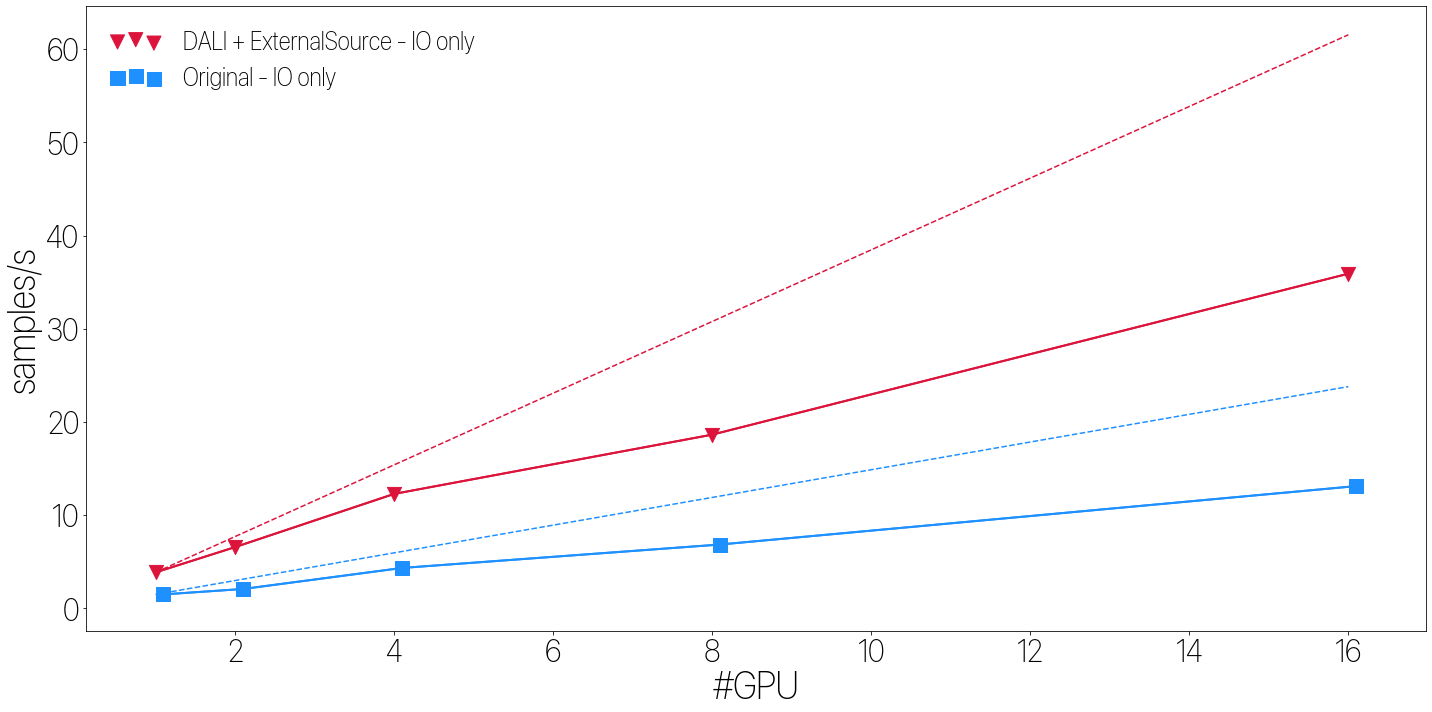

In [105]:
numrows = 1
numcols = 1
fig, ax = plt.subplots(figsize=(20*numcols, 10*numrows), nrows=numrows, ncols=numcols)
ax.set_xlabel('#GPU',fontproperties=font_prop_axis_labels)
ax.set_ylabel('samples/s',fontproperties=font_prop_axis_labels)
ax.set_xticks(np.arange(2,18,2))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontproperties(font_prop_axis)
        label.set_fontsize(32)
        
plotlist = [(0, "dali-sync", "io"), (1, "orig", "io")]
for idx, loader, feature in plotlist:
    # project frame
    selectdf = resultdf[ (resultdf["feature"] == feature) & (resultdf["loader"] == loader) ]
    
    # create label
    label = loadermap[loader] + " - " + featuremap[feature]
    
    ax.plot(selectdf["num_gpus"].values + xshift * idx, 
            selectdf["samples_per_second"]["mean"].values, 
            lw=2,
            color=colorlist[idx])
    ax.scatter(selectdf["num_gpus"].values + xshift * idx, 
                selectdf["samples_per_second"]["mean"].values,
                s=ms,
                marker=markerlist[idx],
                color=colorlist[idx],
                label=label)
    ax.errorbar(selectdf["num_gpus"].values + xshift * idx, 
                selectdf["samples_per_second"]["mean"].values, 
                selectdf["samples_per_second"]["std"].values,
                lw=2,
                color=colorlist[idx])

    #ideal
    slope = selectdf.loc[ (selectdf["num_gpus"] == 1), "samples_per_second"]["mean"].values[0]
    xvals = np.arange(1, 17, 1.)
    yvals = np.array([x*slope for x in xvals])
    ax.plot(xvals, yvals, ls = "--", color = colorlist[idx])

#legend
ax.legend(loc='upper left', ncol=1, scatterpoints=3, frameon = False, prop=font_prop_legend)

# save the plot
plt.tight_layout()
plt.savefig('./pipeline_scaling.png')

### FW + BW

KeyError: 'no-amp'

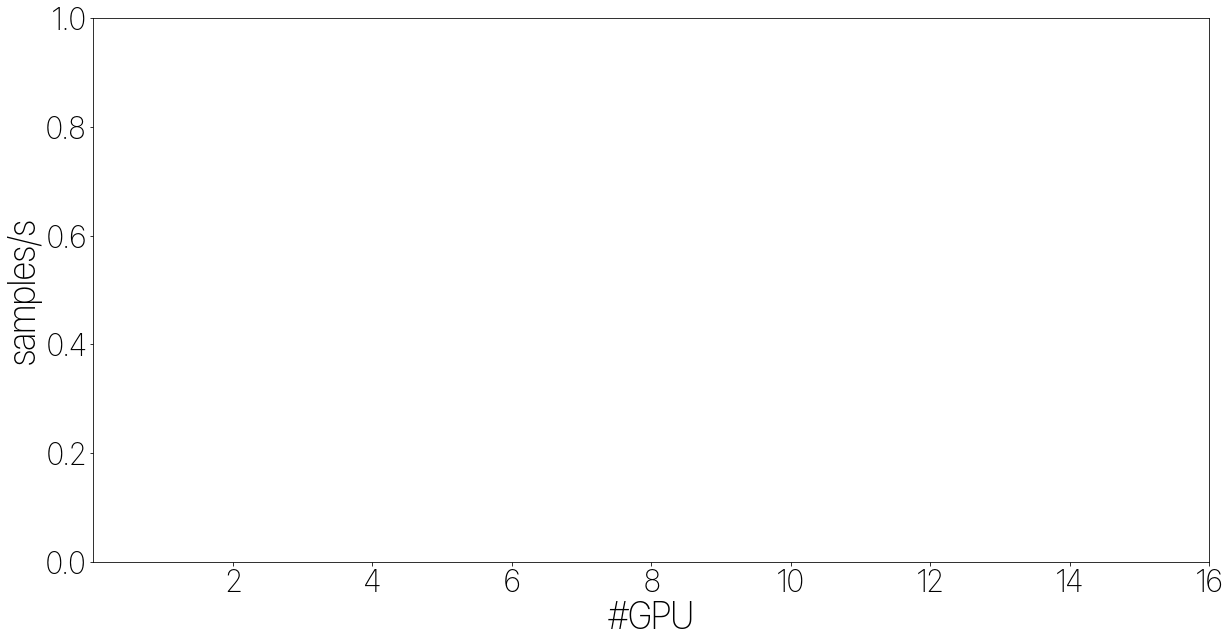

In [106]:
numrows = 1
numcols = 1
fig, ax = plt.subplots(figsize=(20*numcols, 10*numrows), nrows=numrows, ncols=numcols)
ax.set_xlabel('#GPU',fontproperties=font_prop_axis_labels)
ax.set_ylabel('samples/s',fontproperties=font_prop_axis_labels)
ax.set_xticks(np.arange(2,18,2))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontproperties(font_prop_axis)
        label.set_fontsize(32)
        
plotlist = [(0, "dali-sync", "no-amp"), (1, "orig", "no-amp")]
for idx, loader, feature in plotlist:
    # project frame
    selectdf = resultdf[ (resultdf["feature"] == feature) & (resultdf["loader"] == loader) ]
    
    # create label
    label = loadermap[loader] + " - " + featuremap[feature]
    
    ax.plot(selectdf["num_gpus"].values + xshift * idx, 
            selectdf["samples_per_second"]["mean"].values, 
            lw=2,
            color=colorlist[idx])
    ax.scatter(selectdf["num_gpus"].values + xshift * idx, 
                selectdf["samples_per_second"]["mean"].values,
                s=ms,
                marker=markerlist[idx],
                color=colorlist[idx],
                label=label)
    ax.errorbar(selectdf["num_gpus"].values + xshift * idx, 
                selectdf["samples_per_second"]["mean"].values, 
                selectdf["samples_per_second"]["std"].values,
                lw=2,
                color=colorlist[idx])

    #ideal
    slope = selectdf.loc[ (selectdf["num_gpus"] == 1), "samples_per_second"]["mean"].values[0]
    xvals = np.arange(1, 17, 1.)
    yvals = np.array([x*slope for x in xvals])
    ax.plot(xvals, yvals, ls = "--", color = colorlist[idx])

#legend
ax.legend(loc='upper left', ncol=1, scatterpoints=3, frameon = False, prop=font_prop_legend)

# save the plot
plt.tight_layout()
plt.savefig('./pipeline_scaling.png')